> - author: Dongwan Kim
- date: 2019-03-13

---

paper
- https://arxiv.org/abs/1803.10122
- https://worldmodels.github.io/

code
- https://github.com/hardmaru/WorldModelsExperiments/tree/master/carracing

reference
- https://medium.com/applied-data-science/how-to-build-your-own-world-model-using-python-and-keras-64fb388ba459
- https://towardsdatascience.com/world-models-in-tensorflow-episode-1-2b3c217ebc8f

about Evolution Strategy
- http://blog.otoro.net/2017/10/29/visual-evolution-strategies/

# 1. Introduction

'인간이 외부의 자극을 어떻게 표상으로 저장하고 사용하는가'에 관한 인지과학에서의 모형이  'Mental Models'이다. Mental Model을 강화학습에서 구현한 것이 model-based RL이고, 이 논문에서는 아래와 같은 방식으로 이야기를 풀어나간다.

인간이 세상을 인지하는 방식은 우리가 인지하는 것들을 추상화하고 이것들의 관계를 머릿속에 저장한다. 또한 현재의 상황에서 할 수 있는 행동에 대해 예상되는 추상화 또한 생산/저장한다.  또한 추상화한 개념과 약간의 예측을 이용해 다음에 할 행동을 결정한다.
1. 인지한 것들을 추상화
2. 추상화한 개념들을 이용해 현재 행동에 대한 다음 추상화를 예측
3. 현재와 (예측된) 미래의 추상화를 이용해 다음에 할 행동을 결정

위에 나열된 각 단계를 각각 하나의 모델로 구성한 것이 World Model인데, 각 단계를 아래와 같이 구현하고 있다.
- 첫번째 단계는 VAE를 이용한 차원축소($x \rightarrow z$)
- 두번째 단계는 MDN-RNN(Mixture Density Network & RNN)을 이용한 다음 상태($z_{t+1}$) 예측
- 세번째 단계는 CMA-ES(최적화 알고리즘 중 하나)를 이용해 reward를 최적화하는 다음 행동 탐색

강화학습 관점에서 생각해보면...    
어떤 상태에서 $s_t$에서 어떤 행동을 할지 결정하는 함수 $C$가 있다고 하자.
$$a_{t+1}  = C_{\theta}(s_t)$$

주어진 문제에서 보상을 부여하는 논리를 아래와 같이 보상 함수 $R$로 표현할 수 있다. 즉 어떤 상태 $s_t$에서 어떤 행동 $a_t$를 하면 보상 $r_t$를 받는 것이다.
$$r_t = R(s_t, a_t) = R(s_t, C_{\theta}(s_{t-1}))$$

주어진 문제를 풀 수 있는 최적의 정책은 누적된 보상을 평균적으로 최대화하는 정책함수 $C$를 찾는 문제라 할 수 있다.

\begin{align}
G &= \sum_{t=1}^T r_t \\
&= \sum_{t=1}^T R(s_t, C_{\theta}(s_{t-1})) \\
\\
&\arg\max_{\theta} \mathbb{E}[G]
\end{align}

여기서 이 함수 $C$의 입력으로 넣을 $s_t$를 어떻게 결정할 것인지와 단지 $s_t$만 넣을 것인지 아니면 다른 좋은? 정보도 넣을것인지 그리고 $C$의 파라미터를 어떻게 최적화 할 것인지 등을 잘 결정해야 한다.

이 논문에서는 VAE를 이용해서 $s_t$를 $z_t$로 압축해 사용하며, $a_t$를 결정할 때 $z_t$뿐만 아니라 지금까지의 상태 시퀀스 정보($h_t$)도 사용한다. 또한 $C$를 최적화하기 위해 CMA-ES를 사용하며, V / M / C를 독립적으로 학습시킨다.

# 2. Agent Model

모델은 아래 3가지로 구성된다.
- V: VAE를 사용해서 입력된 이미지($s_t$)를 $z_t$로 압축한다.
- M: MDN-RNN(Mixture Density Network-RNN)을 사용해서 $P(z_{t+1} \mid a_t, z_t, h_t)$를 모델링한다. 
- C: 간단한 single layer linear model로 다음 행동 $a_t$를 모델링한다. $a_t = W_c [z_t h_t] + b_c$

###### 2.2 MDN-RNN (M) Model

VAE의 $z_t$를 $k$개 node로 구성했다면 MDN은 $m$개의 $k$차원 gaussian의 mixture의 파라미터를 출력하도록 한다. 다만 논문의 예에서는 $k$차원 gaussian은 $k$개의 단변수 gaussian의 곱으로 factorize된다고 가정하고 있다.

\begin{align}
\text{mixture distribution} & =  w_1 \mathcal{N}_{1,1}(\mu_{1,1}, \sigma_{1,1}) \cdot \mathcal{N}_{1,2}(\mu_{1,2}, \sigma_{1,2}) \cdots \mathcal{N}_{1,k}(\mu_{1,k}, \sigma_{1,k}) \\
& + w_2 \mathcal{N}_{2,1}(\mu_{2,1}, \sigma_{2,1}) \cdot \mathcal{N}_{2,2}(\mu_{2,2}, \sigma_{2,2}) \cdots \mathcal{N}_{2,k}(\mu_{2,k}, \sigma_{2,k}) \\
& + \cdots \\
& + w_m \mathcal{N}_{m,1}(\mu_{m,1}, \sigma_{m,1}) \cdot \mathcal{N}_{m,2}(\mu_{m,2}, \sigma_{m,2}) \cdots \mathcal{N}_{m,k}(\mu_{m,k}, \sigma_{m,k}) \\
\end{align}

따라서 MDN의 출력 차원은 $m \times k \times 3$이다. ($m \times k$ 개 gaussian의 mixture weight, mu, sigma를 표현, 코드에서는 m=5, k=32)

# 3. Car Racing Experiment

###### 3.1 World Model for Feature Extraction

OpenAI의 CarRacing-v0 환경에 우리 모델을 적용해본다.

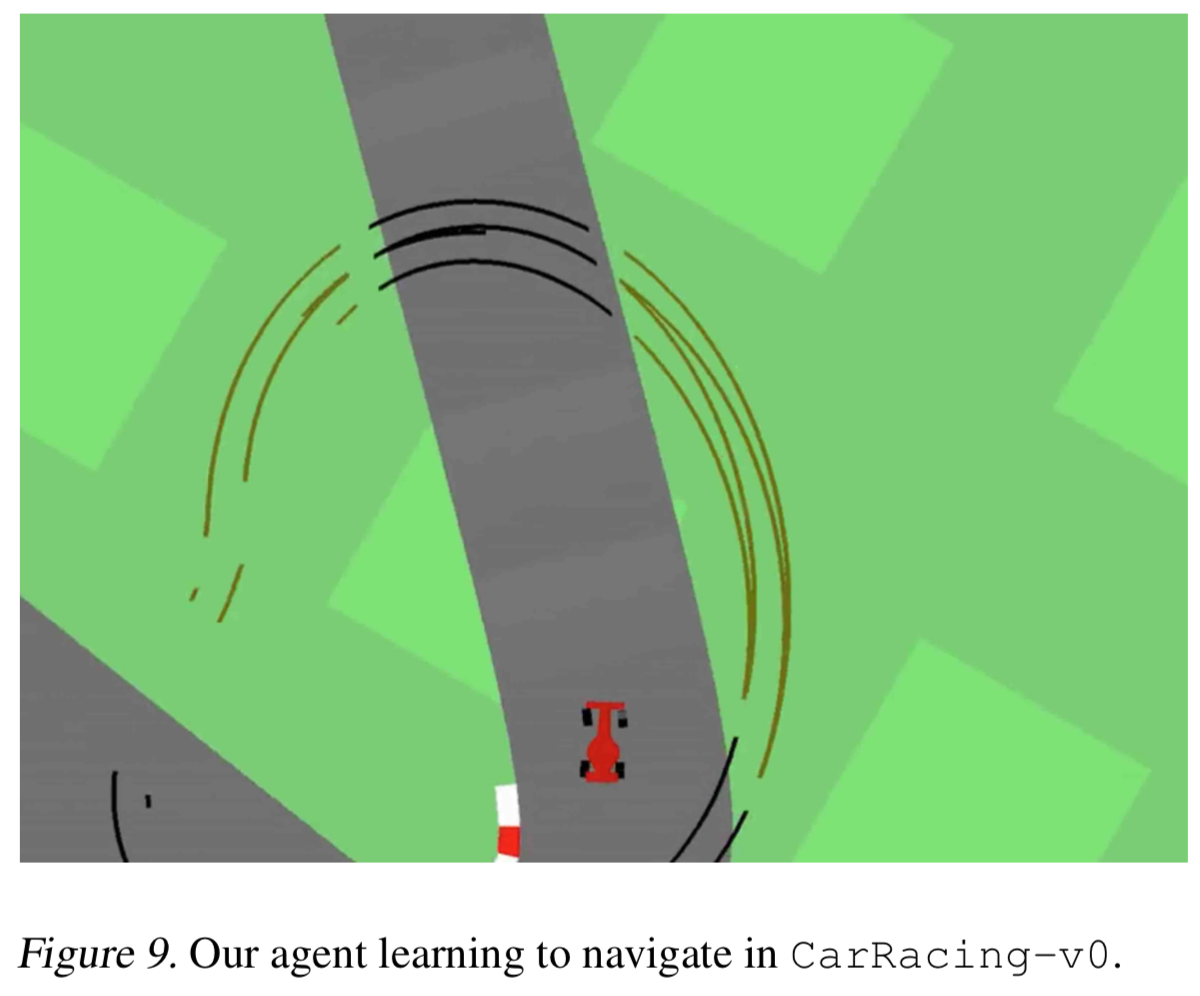

이 환경에서 우리가 컨트롤 할 수 있는 것은 아래 3가지이다.
- 휠을 오른쪽으로 돌릴지, 왼쪽으로 돌릴지
- 엑셀을 밟을 것인지
- 브레이크를 밟을 것인지

우리 모델은 V, M, C로 구성되어 있다고 했는데, 우선 V와 M모델을 학습시키기 위해 무작위 행동을 하는 10만개 rollout 데이터(현재 화면, 무작위 행동, 다음 화면)를 수집한다. 그리고 화면 데이터를 이용해 VAE모델을 학습시킨다.

다음으로 10만개 rollout의 화면을 앞서 학습시킨 V모델을 이용해 $z$로 축약한다. 이 과정을 거치면 데이터는 ($z_{t-1}, a_t, z_t$)로 바뀌게 된다. 이렇게 변환된 데이터를 이용해 MDN-RNN을 학습시킨다. 즉 현재 상태($z_t$), 현재 행동($a_t$), 미래 상태($h_t$)를 이용해 다음 상태 $z_{t+1}$을 예측하는 모델을 학습시킨다.

V모델과 M모델을 독립적으로 학습시켰고, 이제 실제 환경에 에이전트를 풀어놓고 C모델의 파라미터를 최적화 한다.  파라미터를 최적화 하는 과정은 CMA-ES알고리즘을 이용하는데 그냥 여러 파라미터 조합에 대해 rollout을 실행해보고 reward가 높은 파라미터 조합을 찾아가는 방법이다. 

###### 3.3 Experiment Results

- V Model Only (without prediction)

> 현재 상태를 피쳐들로 잘 표현할수만 있다면 이것 만으로도 에이전트를 잘 학습시킬 수 있다는게 알려져 있다. 그래서 우리 모델에서 현재 상태의 압축적 표현이라 할 수 있는 $z_t$만을 이용해 컨트롤러를 학습시켜봤다. 즉 아래와 같은 모델을 학습시키는 것이다. (앞서의 모델과 달리 미래 정보 혹은 지금까지 시퀀스에 대한 압축된 정보를 의미하는 $h_t$를 사용하지 않음)
$$a_t = W_c z_t + b_c$$   
이렇게 해봤더니 트렉을 돌기는 하지만 $h_t$를 사용할 때보다 많이 부정확한 궤적을 진행하는 문제가 있었다. 컨트롤 네트워크에 히든 레이어를 추가해서도 해 봤지만 크게 향상되지는 않았다.

- Full World Model(V and M)

> $z_t$는 현재 상태에 대한 정보라 할 수 있고, $z_{t+1}$은 다음 시점의 상태 정보라 할 수 있다. 그런데 $h_{t}$를 이용해 $z_{t+1}$를 구하기 때문에 $h_{t}$는 현재까지 시퀀스 입력을 포괄하는 정보라 할 수 있고, 이건 컨트롤러가 다음 행동을 선택하는데 매우 유용한 정보라 할 수 있다. 그래서 $z_t$와 $h_t$를 모두 컨트롤러에 전달하는 아래 모델을 사용해 봤다.
$$a_t = W_c [z_t h_t] + b_c$$
> 이렇게 해봤더니 $z_t$만 사용할 때보다 훨신 코더를 잘 통과하는걸 볼 수 있었다.   
> 또한 100번 랜덤 시행에 대한 성능을 보면 906점으로 기존 가장 높은 점수인 838점을 뛰어넘었다.

###### 3.4 Car Racing Dreams (Real policy into a Dream)

M모델을 이용하면 $z_t$가 주어졌을 때 $z_{t+1}$에 대한 확률 분포를 구할 수 있다. 또한 이 확률 분포에서 샘플을 얻으면 미래 시점에 압축된 시각 정보를 표현하는 벡터를 얻을 수 있다. 이 벡터를 V모델로 reconstruct하면 미래 시점의 화면이 어떨지 눈으로 확인할수도 있다.(물론 뿌옇긴하다.) 

M 모델을 이용해 생성할 수 있는 $z$ 시퀀스($z_t, z_{t+1}, z_{t+2}, \cdots$)는 실제하지는 않지만 개념화된 정보들로서 이 논문에서는 환각(hallucination) 혹은 꿈(dream)이라 부른다.



gym에 action을 던졌을 때 반환하는 이미지들로 C를 학습시키고, 어차피 C는 $z_t, \cdots$을 이용해 inference하므로, 꿈에서도 이 모델을 사용해볼수도 있다.    
(다만 C를 학습시킬 때 사용했던 M모델과 꿈을 생성하는 M모델이 같다면 반칙이라고도 볼 수 있다.)

# 4. VizDoom Experiment

###### 4.1 Learning Inside of a Dream (Dream policy into a Real world)

- train VMC in the gym, play in a real
 1. gym에서 랜덤한 rollout 데이터 수집
 2. V 모델 학습
 3. M 모델 학습
 4. gym에서 C모델 학습 (gym이 내놓는 이미지를 V로 압축($z_t)$하고, M모델로 $h_t$구하고, C모델로 $a_t$구해서 누적 보상 구한 후 최적의 $W_c, b_c$구함.)
 5. 학습된 C 모델로 gym에서 주행

- train VMC in the gym, play in a dream
 1. gym에서 랜덤한 rollout 데이터 수집
 2. V 모델 학습
 3. M 모델 학습
 4. gym에서 C모델 학습 (gym이 내놓는 이미지를 V로 압축($z_t)$하고, M모델로 $h_t$구하고, C모델로 $a_t$구해서 누적 보상 구한 후 최적의 $W_c, b_c$구함.)
 5. 학습된 C 모델로 M가 생성하는 dream에서 주행

- train VM in the gym, train C in a dream, play in a dream or gym
 1. gym에서 랜덤한 rollout 데이터 수집
 2. V 모델 학습
 3. M 모델 학습
 4. M이 생성하는 $z$ 시퀀스에서 C모델 학습 (M모델이 생성하는 $z_t, h_t$를 C모델에 넣어 $a_t$를 구하고, 누적 보상 구해서 최적의 $W_c, b_c$구함.)
 5. 학습된 C 모델로 M가 생성하는 dream/gym에서 주행

현실에서 학습시킨 C모델을 꿈에서 활용할 수 있다면, 반대로 꿈에서 학습시킨 C모델을 현실에서 사용해볼 수도 있을 것이다. 즉 실제 이미지 입력을 사용하지 않고, M모델로 생성한 $z$ 시퀀스 만으로 C모델을 학습시키고, 이 컨트롤러가 괜찮다면 실제 gym에서 사용해볼수도 있을 것이다.

이 실험을 VizDoom 환경에서 해 보았다.

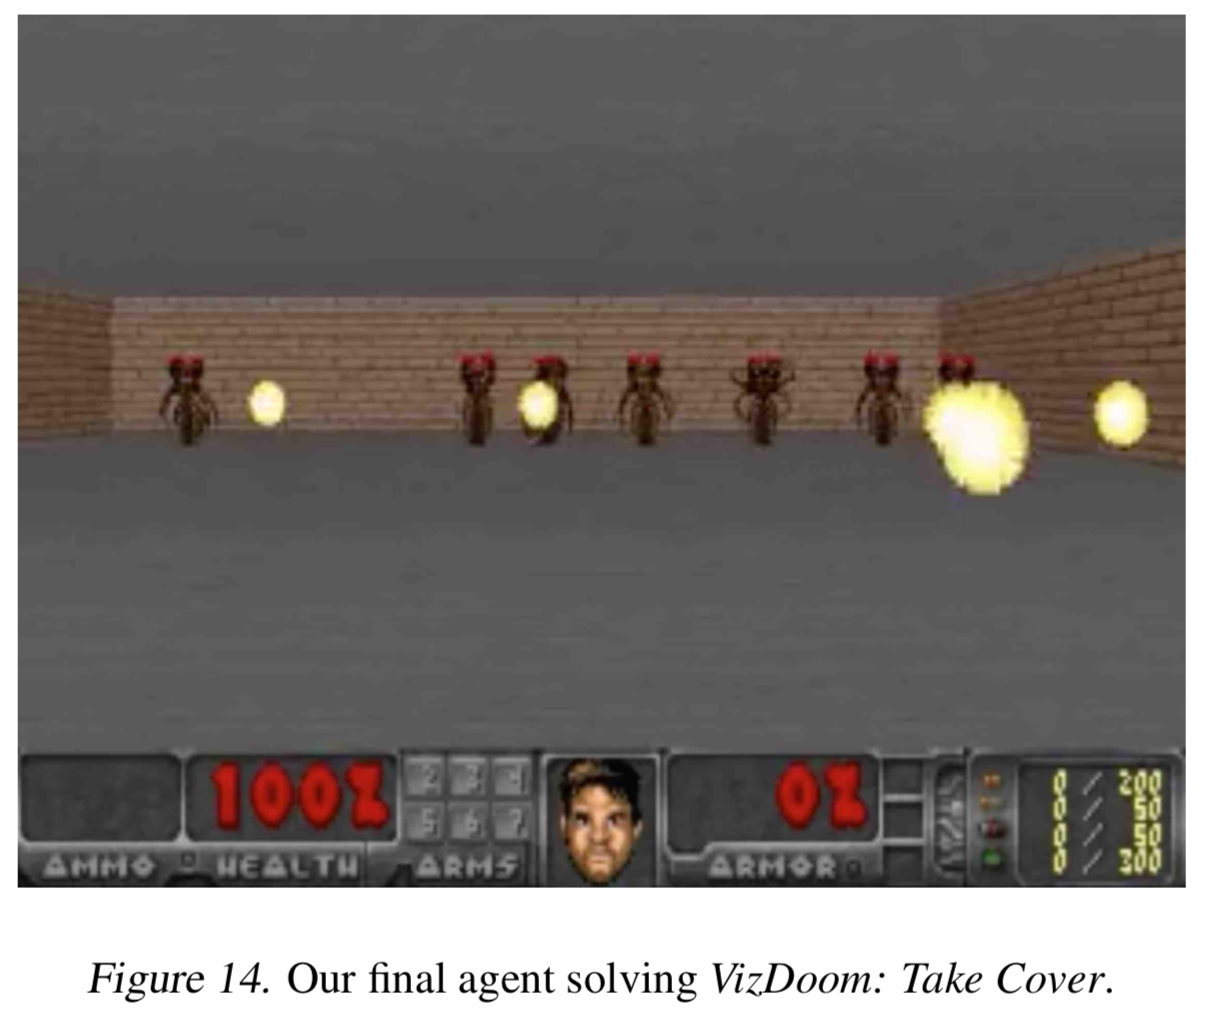

몬스터가 쏘는 파이어볼을 잘 피하면 되는 게임인데, 보상은 얼마나 오랫동안 살아남았는지로 결정한다. 한 게임은 최대 2100 시점(60초)이며, 100 게임에서 평균 750 시점 이상 살아남으면 문제가 풀린 것으로 간주한다.

###### 4.2 Procedure

앞서 Car Racing  문제와 달라진점은 앞서 M모델이 $z_t$만을 예측하도록 했다면, VizDoom에서는 M모델이 $z_t$ 뿐만 에이전트가 죽었는지 아닌지($done_t$) 또한 예측한다.

dream에서 학습하기 위해 M모델이 생성한 $z_t$와 $h_t$를 C에 입력으로 넣어 $a_t$를 구하고, 다시 $[z_t, h_t, a_t]$를 M모델에 입력으로 넣어 $z_{t+1}, h_{t+1}$를 구하고 C를 이용해 $a_{t+1}$을 구하는 과정을 반복한다. 만약 M모델이 예측한 $done$가 참이면 rollout을 멈춘다.

그리고 이렇게 학습시킨 C모델을 실제 gym에서 사용한다.

###### 4.3 Training Inside of the Dream

- 학습시킨 M모델로 생성한 시퀀스를 보면 실제 게임 플레이처럼 오른쪽으로 움직이는 행동 다음에는 화면이 오른쪽으로 움직이고, 벽에 박히는 부분에서는 행동이 주어져도 화면이 변하지 않는다.
- MDN에서 $z$를 샘플링할 때 temperature 파라미터 $\tau$를 이용해 샘플의 불확실성을 조절할 수 있다. 샘플의 불확실성이 커진다면 예상과 다른 다음 화면이 나올 수 있으므로 게임이 어려워지는 효과가 생긴다고 생각할 수 있다.

###### 4.4 Transfer Policy to Actual Environment

dream에서 학습한 컨트롤러를 실제 gym환경에서 테스트해 봤더니 성능이 괜찮았다.

###### 4.5 Cheating the World Model

M모델로 게임 화면과 로직을 표현하긴 했지만 그것을 근사한 것이라서, 실제 게임에서는 불가능한 트릭을 만들기도 한다. 예를들어 특정 상태에서 특정 행동을 하면 파이어볼이 모두 사라지는 현상이 생기기도 했다. 컨트롤러를 학습시킬 때 단지 누적된 보상을 최대화하면 되므로, 실제 게임에서는 불가능하더라도 M모델이 생성해주는 이런 트릭을 이용하도록 학습된다.

앞서 temperature 파라미터 $\tau$를 바꿔서 샘플의 불확실성을 조절할 수 있다고 했는데, 이 값에 따라 모델 성능이 달라지고, 최적의 $\tau$값을 찾으면 더 나은 모델 성능을 기대할 수 있다.

# 5. Interative Training Procedure

앞서 실험에서는 랜덤한 정책으로 수집한 데이터를 사용했었다. 간단한 문제는 랜덤 정책으로 수집한 데이터로도 잘 학습되지만 문제가 복잡해지면 잘 되지 않는다. 복잡한 문제에 대해서는 초기 랜덤 정책을 개선하면서 데이터를 수집하고 그걸로 학습해야 한다.

- 랜덤 정책 이용하는 경우
 1. 랜덤 정책으로 데이터 수집
 2. 위 데이터로 V, M학습
 3. gym에서 C학습

- Interactive Traning
 1. 정책을 랜덤하게 세팅
 2. 데이터 수집해서 V학습
 3. M 모델($P(x_{t+1}, r_{t+1}, a_{t+1} \mid x_t, a_t, h_t)$학습, C모델 학습
 4. 2로 가서 반복.

# 6. Related Work

모델을 먼저 학습하고 이걸 이용해 정책을 학습하는 접근(model based RL)에 관한 연구는 오래 전부터 많이 진행되어 왔다.
- FNN, RNN, GP, Bayesian neural network 을 사용하는 접근들이 있었다. 그런데 이런 모델들은 관측 입력의 차원이 작을때 잘 동작한다는 문제점이 있다. 
- 입력 차원이 큰 문제를 해결하기 위해 Autoencoder를 사용하는 연구(Finn et al., 2015)
- 여러 프레임에 걸친 정보를 표현하기 위해 RNN을 사용하는 연구(Graves, 2013)
- 이 논문의 world model에 대한 아이디어는 위르겐 슈미드후버의 1990년 논문인 'Making the World Differentiable'에 등장한다.(Schmidhuber, 1990a)

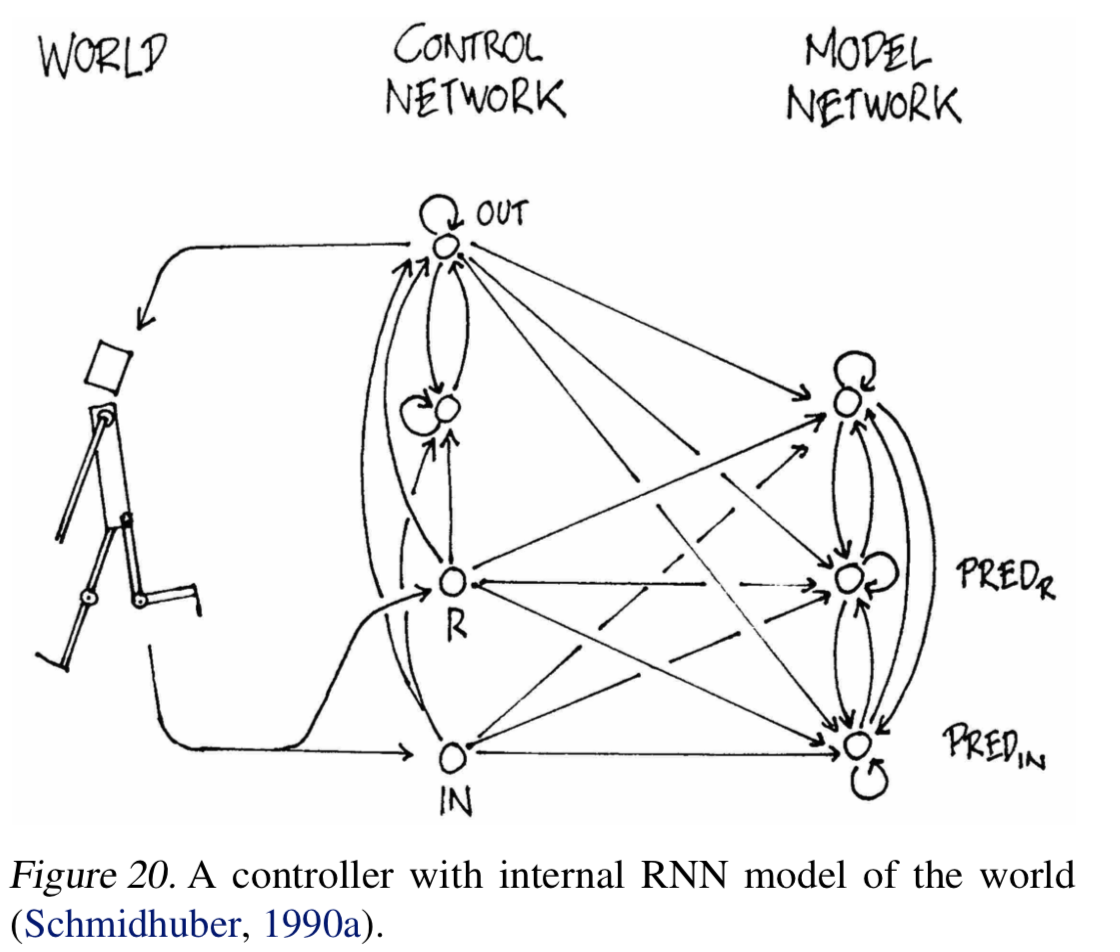

C모델을 학습시킬때 진화알고리즘(ES)를 사용하는데, 이걸 사용하면 rollout의 각 스텝마다의 reward 대신 누적된 reward값만을 알면 되고, 쉽게 그 계산을 병렬화 할 수 있는 장점이 있다. 

# 7. Discussion

- 꿈속에서 컨트롤러를 학습시키는걸 다뤘었는데, 에이전트가 환경으로 부터 받는 정보가 큰 이미지나 음성처럼 무거운 경우 이미지나 음성을 압축한 꿈 속에서 학습을 진행하면 보다 가볍게 컨트롤러를 학습시킬 수 있고, GPU를 이용한 분산 환경에서도 쉽게 학습이 가능하다.

- 이미지 입력을 압축하기 위해 M이나 C와는 독립적인 V모델로 VAE를 사용하고 있다. 그런데 이 VAE를 학습시킬 때 이미지의 어느 부분이 중요한지에 대한 정보를 전혀 주지 않는다. 즉 비지도 학습을 하고 있는데, 이 때문에 둠 이미지에서 게임 점수를 높게 받는 것과 전혀 관계 없는 타일의 디테일한 형상을 VAE가 잘 학습하고 있다. 반면 주행 이미지에서는 주행과 밀접한 관계가 있는타일의 디테일을 잘 표현하지 못하고 있다. 

- V모델을 독립적으로 학습시키면 게임의 룰이 바뀌더라도 V모델을 재사용할 수 있는 장점이 있다. 물론 V가 게임의 룰을 감안하도록 M모델과 같이 학습시킬 수도 있는데, 이렇게 하면 게임의 룰이 바뀔 경우 V모델 또한 다시 학습시켜야 한다.

- RNN(LSTM)모델의 한계 또한 앞으로 고찰해볼만한 부분이다. 사람은 몇년전 기억까지도 끄집어내어 오늘의 결정에 중요한 요인으로 사용할 수 있다. 하지만  RNN은 그렇게 길지 않은 시퀀스만을 기억할 뿐인 한계가 있다.